<a href="https://colab.research.google.com/github/zapell/zapell.github.io/blob/master/442_final_project/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import pickle
from PIL import Image
import glob
import re
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
#from scipy.misc import imresize
from skimage.transform import resize
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/My Drive/442_final/Fnt.zip'
!cp "{zip_path}" .
!unzip -q Fnt.zip

In [ ]:
!rm Fnt.zip

In [ ]:
ls

drive/  Fnt/  __MACOSX/  sample_data/


In [ ]:
pth = ('Fnt/')
fldrs = os.listdir(pth)
print(fldrs)

['Sample039', 'Sample017', 'Sample042', 'Sample057', 'Sample033', 'Sample027', 'Sample025', 'Sample018', 'Sample061', 'Sample006', 'Sample021', 'Sample034', 'Sample032', 'Sample045', 'Sample044', 'Sample043', 'Sample036', 'Sample035', 'Sample008', 'Sample030', 'Sample052', 'Sample047', 'Sample010', 'Sample046', 'Sample056', 'Sample004', 'Sample011', 'Sample055', 'Sample029', 'Sample019', 'Sample013', 'Sample049', 'Sample060', 'Sample041', 'Sample059', 'Sample009', 'Sample024', 'Sample012', 'Sample040', 'Sample053', 'Sample048', 'Sample026', 'Sample023', 'Sample054', 'Sample037', 'Sample014', 'Sample001', 'Sample062', 'Sample022', 'Sample020', 'Sample031', 'Sample015', 'Sample051', 'Sample003', 'Sample050', 'Sample005', 'Sample016', 'Sample028', 'Sample002', 'Sample038', 'Sample007', 'Sample058']


In [ ]:
# load character folders
def loadChars74k(images, labels, path):
    # list of directories
    dirlist = [ item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item)) ]
    print(dirlist)
    # for each subfolder, open all files, append to list of images x and set path as label in y
    for subfolder in dirlist:
        imagePath = glob.glob(path + '/' + subfolder +'/*.png')
        im_array = np.array( [np.array(Image.open(imagePath[i]).convert('L'), 'f').ravel() for i in range(len(imagePath))] )
        images.append(im_array)
        print(len(images))
        # split into char and nums
        temp = re.compile("([a-zA-Z]+)([0-9]+)") 
        res = temp.match(subfolder).groups() 
        # labels list
        labels.append(res[1])

    return images, labels

In [ ]:
img = []
lbl = []
img, lbl = loadChars74k(img, lbl, pth)

['Sample039', 'Sample017', 'Sample042', 'Sample057', 'Sample033', 'Sample027', 'Sample025', 'Sample018', 'Sample061', 'Sample006', 'Sample021', 'Sample034', 'Sample032', 'Sample045', 'Sample044', 'Sample043', 'Sample036', 'Sample035', 'Sample008', 'Sample030', 'Sample052', 'Sample047', 'Sample010', 'Sample046', 'Sample056', 'Sample004', 'Sample011', 'Sample055', 'Sample029', 'Sample019', 'Sample013', 'Sample049', 'Sample060', 'Sample041', 'Sample059', 'Sample009', 'Sample024', 'Sample012', 'Sample040', 'Sample053', 'Sample048', 'Sample026', 'Sample023', 'Sample054', 'Sample037', 'Sample014', 'Sample001', 'Sample062', 'Sample022', 'Sample020', 'Sample031', 'Sample015', 'Sample051', 'Sample003', 'Sample050', 'Sample005', 'Sample016', 'Sample028', 'Sample002', 'Sample038', 'Sample007', 'Sample058']
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


In [ ]:
# repeat labels for 1016 labels (num pics each char)
lbl = np.repeat(lbl, 1016)
len(lbl)

62992

In [ ]:
# stack folders to get one array
img = np.vstack(img)
#reshape into 128x128
img = img.reshape((img.shape[0], 128,128))

In [ ]:
def resize_image(X, image_dim):
    """
    Resizes the data partition X to the size specified in the config file.
    Uses bicubic interpolation for resizing.

    Returns:
        the resized images as a numpy array.
    """
    resized = []
    for i in range(len(X)):
        resized.append(resize(X[i], (image_dim,image_dim)))
    return resized

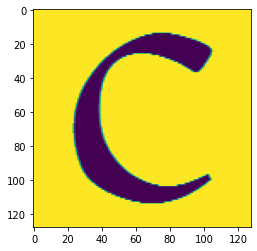

In [ ]:
#orig img
plt.imshow(img[0])

In [ ]:
class ImageStandardizer(object):
    """
    Channel-wise standardization for batch of images to mean 0 and variance 1. 
    The mean and standard deviation parameters are computed in `fit(X)` and
    applied using `transform(X)`.
    
    X has shape (N, color_channel,image_height, image_width)
    """
    def __init__(self):
        super().__init__()
        self.image_mean = None
        self.image_std = None
    
    def fit(self, X):
        # TODO: Complete this function
        self.image_mean = []
        self.image_std = []
        
        self.image_mean = np.mean(X, axis = (0,2,3))
        self.image_std = np.std(X, axis=(0,2,3))
        
        return 

    def transform(self, X):
        # TODO: Complete this function
        X = ((X-self.image_mean)/self.image_std)
        return X

In [ ]:
img = resize_image(img, 32)
#imr = images

In [ ]:
img = np.array(img)
img.shape

(62992, 32, 32)

In [ ]:
# clipping instead of smoothing
img = np.where(img>200,255,0)
# add channel dim
img = img.reshape((img.shape[0],1,img.shape[1],img.shape[2]))

In [ ]:
# 80/20 train/test
train_size = int(np.ceil(.8*img.shape[0]))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img, lbl, test_size = .2, random_state=442)

In [ ]:
# offset labels to match up with 0 indexing
y_train = y_train.astype(np.int)
y_train = y_train - 1
y_test = y_test.astype(np.int)
y_test = y_test - 1

In [ ]:
# split into train/val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=442)

In [ ]:
# standardize img
standardizer = ImageStandardizer()
standardizer.fit(X_train)
X_train = standardizer.transform(X_train)
X_val = standardizer.transform(X_val)
X_test = standardizer.transform(X_test)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
train = MyDataset(X_train, y_train)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
val = MyDataset(X_val, y_val)
val_loader = DataLoader(val, batch_size=64, shuffle=True)
test = MyDataset(X_test, y_test)
test_loader = DataLoader(test, batch_size=64, shuffle=True)

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=128, kernel_size=3,padding=1)
        self.fc1 = nn.Linear(128*4*4, 256) 
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,62) # from hidden layer to 10 class scores

    def forward(self,x):
        #print(x.shape)
        #x = x.view(-1,32*32) # Flatten each image in the batch
        #print(x.shape)
        relu = nn.ReLU()
        pool = nn.MaxPool2d(2)
        drop = nn.Dropout2d(.3)
        bn = nn.BatchNorm2d(16)
        #print('before: ', x.shape)
        x = self.conv1(x)
        x = bn(x)
        x = drop(x)
        x = relu(x)
        #print('conv1: ', x.shape)
        x = pool(x)
        #print('pool1:',x.shape)
        x = self.conv2(x)
        x = drop(x)
        #print('conv2: ', x.shape)
        x = relu(x)
        x = pool(x)
        x = self.conv3(x)
        x = drop(x)
        #print('conv3: ', x.shape)
        x = relu(x)
        x = pool(x)
        #print('pool3: ', x.shape)
        x = x.reshape(-1, 128*4*4)
        x = self.fc1(x)
        x = drop(x)
        #print('fc1: ', x.shape)
        x = self.fc2(x)
        #x = drop(x)
        #print('fc2: ', x.shape)
        x = self.fc3(x)
        #print('out: ', x.shape)
        #print(x.shape)
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Configure device
model = Network().to(device)
criterion = nn.CrossEntropyLoss() # Specify the loss layer
# TODO: Modify the line below, experiment with different optimizers and parameters (such as learning rate)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) # Specify optimizer and assign trainable parameters to it, weight_decay is L2 regularization strength
num_epoch = 30 # TODO: Choose an appropriate number of training epochs
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)
val_loss = []
train_loss = []

In [ ]:
def train(model, loader, valloader, num_epoch = 10): # Train the model
    print("Start training...")
    model.train() # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        for batch, label in tqdm(loader, position=0):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad() # Clear gradients from the previous iteration
            pred = model(batch) # This will call Network.forward() that you implement
            #print(pred, label)
            loss = criterion(pred, label) # Calculate the loss
            running_loss.append(loss.item())
            loss.backward() # Backprop gradients to all tensors in the network
            optimizer.step()
        # val loss
        val_r_loss = []
        for batch_v, label_v in tqdm(valloader, position=0):
            batch_v = batch_v.to(device)
            label_v = label_v.to(device)
            #optimizer.zero_grad() # Clear gradients from the previous iteration
            pred_v = model(batch_v) # This will call Network.forward() that you implement
            loss_v = criterion(pred_v, label_v) # Calculate the loss
            val_r_loss.append(loss_v.item())
        val_loss.append(np.mean(val_r_loss))
        scheduler.step()
        ## end val loss code
        train_loss.append(np.mean(running_loss))        
        print("Epoch {} loss:{}".format(i+1,np.mean(running_loss))) # Print the average loss for this epoch
    print("Done!")

def evaluate(model, loader): # Evaluate accuracy on validation / test set
    model.eval() # Set the model to evaluation mode
    correct = 0
    with torch.no_grad(): # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader, position=0):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
    acc = correct/len(loader.dataset)
    print("Evaluation accuracy: {}".format(acc))
    return acc
    

In [ ]:
train(model, train_loader, val_loader, 40)

  0%|          | 0/315 [00:00<?, ?it/s]

Start training...


  1%|          | 2/315 [00:00<00:30, 10.23it/s]

Epoch 1 loss:1.4219488234747024


  0%|          | 1/315 [00:00<00:32,  9.81it/s]

Epoch 2 loss:0.716532372103797


  1%|          | 2/315 [00:00<00:29, 10.55it/s]

Epoch 3 loss:0.6285583261459593


  1%|          | 2/315 [00:00<00:29, 10.63it/s]

Epoch 4 loss:0.5755895340253436


  1%|          | 2/315 [00:00<00:29, 10.69it/s]

Epoch 5 loss:0.5392155143949721


  1%|          | 2/315 [00:00<00:29, 10.46it/s]

Epoch 6 loss:0.5091446205737099


  1%|          | 2/315 [00:00<00:29, 10.71it/s]

Epoch 7 loss:0.4963680793368627


  1%|          | 2/315 [00:00<00:29, 10.74it/s]

Epoch 8 loss:0.47588215167560277


  1%|          | 2/315 [00:00<00:30, 10.42it/s]

Epoch 9 loss:0.4640444520920042


  1%|          | 2/315 [00:00<00:28, 10.87it/s]

Epoch 10 loss:0.44705271474898806


  1%|          | 2/315 [00:00<00:29, 10.60it/s]

Epoch 11 loss:0.4418065790146116


  1%|          | 2/315 [00:00<00:29, 10.56it/s]

Epoch 12 loss:0.43523263510257476


  1%|          | 2/315 [00:00<00:29, 10.47it/s]

Epoch 13 loss:0.4247399852862434


  1%|          | 2/315 [00:00<00:29, 10.67it/s]

Epoch 14 loss:0.4157213145778293


  1%|          | 2/315 [00:00<00:29, 10.67it/s]

Epoch 15 loss:0.4111552732804465


  1%|          | 2/315 [00:00<00:29, 10.65it/s]

Epoch 16 loss:0.3514573053708152


  1%|          | 2/315 [00:00<00:29, 10.68it/s]

Epoch 17 loss:0.3267440508282374


  1%|          | 2/315 [00:00<00:28, 10.92it/s]

Epoch 18 loss:0.31922799211645886


  1%|          | 2/315 [00:00<00:29, 10.61it/s]

Epoch 19 loss:0.30857261830852145


  1%|          | 2/315 [00:00<00:29, 10.44it/s]

Epoch 20 loss:0.3069201251817128


  1%|          | 2/315 [00:00<00:30, 10.25it/s]

Epoch 21 loss:0.30360529678208487


  1%|          | 2/315 [00:00<00:29, 10.63it/s]

Epoch 22 loss:0.29842785398165383


  1%|          | 2/315 [00:00<00:30, 10.38it/s]

Epoch 23 loss:0.29650448125506207


  1%|          | 2/315 [00:00<00:29, 10.71it/s]

Epoch 24 loss:0.2958787827737748


  1%|          | 2/315 [00:00<00:28, 10.80it/s]

Epoch 25 loss:0.2869681415103731


  1%|          | 2/315 [00:00<00:29, 10.59it/s]

Epoch 26 loss:0.2896554808294962


  0%|          | 1/315 [00:00<00:31,  9.96it/s]

Epoch 27 loss:0.28422484360043965


  1%|          | 2/315 [00:00<00:28, 10.83it/s]

Epoch 28 loss:0.28079339062410685


  1%|          | 2/315 [00:00<00:29, 10.72it/s]

Epoch 29 loss:0.2802277423559673


  1%|          | 2/315 [00:00<00:29, 10.71it/s]

Epoch 30 loss:0.28175040138146235


  1%|          | 2/315 [00:00<00:29, 10.51it/s]

Epoch 31 loss:0.2740865502565626


  0%|          | 1/315 [00:00<00:32,  9.62it/s]

Epoch 32 loss:0.27162789423314354


  0%|          | 1/315 [00:00<00:33,  9.44it/s]

Epoch 33 loss:0.26915048308788786


  1%|          | 2/315 [00:00<00:29, 10.58it/s]

Epoch 34 loss:0.26955962710910375


  1%|          | 2/315 [00:00<00:28, 10.86it/s]

Epoch 35 loss:0.26795830641474044


  1%|          | 2/315 [00:00<00:30, 10.33it/s]

Epoch 36 loss:0.2672123358363197


  0%|          | 1/315 [00:00<00:33,  9.45it/s]

Epoch 37 loss:0.26910638293576616


  1%|          | 2/315 [00:00<00:29, 10.49it/s]

Epoch 38 loss:0.2669253197927324


  0%|          | 1/315 [00:00<00:34,  9.19it/s]

Epoch 39 loss:0.2655443241435384


100%|██████████| 158/158 [00:03<00:00, 48.22it/s]

Epoch 40 loss:0.26606643233034344
Done!


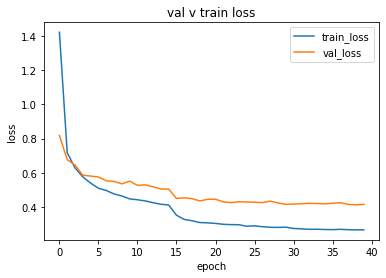

In [ ]:
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('val v train loss')
plt.legend()
plt.show()

In [ ]:
print("Evaluate on validation set...")
evaluate(model, val_loader)
print("Evaluate on test set")
evaluate(model, test_loader)

  0%|          | 0/158 [00:00<?, ?it/s]

Evaluate on validation set...


  3%|▎         | 5/197 [00:00<00:04, 44.42it/s]

Evaluation accuracy: 0.8635777358864967
Evaluate on test set


100%|██████████| 197/197 [00:03<00:00, 49.49it/s]

Evaluation accuracy: 0.8617350583379634


0.8617350583379634

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd content

[Errno 2] No such file or directory: 'content'
/root


In [ ]:
cd ..


/


In [ ]:
cd content/drive/My\ Drive/442_final

/content/drive/My Drive/442_final


In [ ]:
X_train.shape

(40314, 1, 32, 32)

In [ ]:
import pdfBoxes
import Test_CharSeg as TC

In [ ]:
!pip install pdf2image

  Created wheel for pdf2image: filename=pdf2image-1.12.1-cp36-none-any.whl size=9027 sha256=ebd23ca5e283021c9057f4b95b37f16351065f4adc1bd54038764d5afdaf65d5
  Stored in directory: /root/.cache/pip/wheels/0f/80/3a/fac1dc0f7dbe12c805b9dc6497f325f0e9f9cedbec3ab0185b
Successfully built pdf2image


In [ ]:
path = 'input0_Arial.pdf'
pdfB = pdfBoxes.pdfBoxes(filePath=path)
o1, o2 = pdfB.get_bounding_boxes()
lines = o1[0]
for i in range(len(lines)):
  #print(lines[i].shape)
  lines[i] = resize_image(lines[i],32)
  lines[i] = np.array(lines[i])
  #print(lines[i].shape)
  lines[i] = lines[i].reshape((lines[i].shape[0],1,32,32))
  lines[i] = standardizer.transform(lines[i])
  lines[i] = torch.from_numpy(lines[i]).float()

output = []
for i in range(len(lines)):
  loader = DataLoader(lines[i])
  model.eval() # Set the model to evaluation mode
  model = model.float()
  correct = 0
  with torch.no_grad(): # Do not calculate grident to speed up computation
      out = []
      for batch in tqdm(loader, position=0):
          batch = batch.to(device)
          pred = model(batch)
          pred = torch.argmax(pred,dim=1)
          pred = pred.item()
          out.append(pred)
  output.append(out)
chars_lines = []
for i in output:
  chars = []
  for j in range(len(i)):
    val = i[j] + 1
    if val <= 10:
      val += 47
    elif val > 10 and val < 37:
      val += 54 
    else:
      val += 60
    c = chr(val)
    chars.append(c)
  chars_lines.append(chars)

file1 = open("output0_Arial.txt","w") 
print('\n')
for i in range(len(o2[0])):
  line = chars_lines[i]
  curr = 0
  j = 0
  l = ""
  while j < len(line):
    if curr != o2[0][i][0].shape[0] and j == o2[0][i][0][curr]:
      l += line[j]
      l += " "
      curr += 1
      j += 1
    else:
      l += line[j]
      j += 1
  l += '\n'
  file1.writelines(l)
file1.close()


100%|██████████| 76/76 [00:00<00:00, 666.59it/s]

In [ ]:
!apt-get install poppler-utils 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.10 [154 kB]
Fetched 154 kB in 1s (306 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.10_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.10) ...
Setting up poppler-utils (0.62.0-2ubuntu2.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
